Author: Carlos Roberto de Melo

Date: 08/10/2020

Obj:
1. Cortar a imagem WHT do HST com as mesmas dimensões dos dados.
2. Por o MGE peak no centro das imagens
2. Obter o Noise-Map (RMS standard deviations).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Image, WCS
from mpdaf.obj import deg2sexa, sexa2deg

[INFO] 2036 x 2067 Image (/home/carlos/Documents/Dados Projeto/SDP.81/Hubble/hst_12194_01_wfc3_ir_f160w_drz.fits)
[INFO] .data(2036 x 2067) (no unit), no noise
[INFO] center:(00:39:06.5657,09:03:12.1281) size:(183.240",186.030") step:(0.090",0.090") rot:0.0 deg frame:FK5


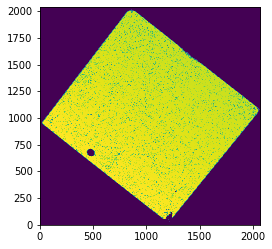

In [2]:
#Abrindo a imagem original na sua extensão WHT .fits e plotando.
img = Image('/home/carlos/Documents/Dados Projeto/SDP.81/Hubble/hst_12194_01_wfc3_ir_f160w_drz.fits', ext=1)
wht_f160w = Image('/home/carlos/Documents/Dados Projeto/SDP.81/Hubble/hst_12194_01_wfc3_ir_f160w_drz.fits', ext=2)
wht_f160w.info()
wht_f160w.plot(zscale=True)

In [3]:
#Define o centro onde será feito o primeiro corte. Estamos usando os mesmos valores utilizados para realizar o corte de 15''
#Feito no arquivo 
CentralPx = (0.651817, 135.798) #Central pixel. The format is (y,x) [deg]
CentralPx

(0.651817, 135.798)

[INFO] 200 x 200 Image (/home/carlos/Documents/Dados Projeto/SDP.81/Hubble/hst_12194_01_wfc3_ir_f160w_drz.fits)
[INFO] .data(200 x 200) (no unit), no noise
[INFO] center:(00:39:06.5657,09:03:11.519) size:(18.000",18.000") step:(0.090",0.090") rot:0.0 deg frame:FK5


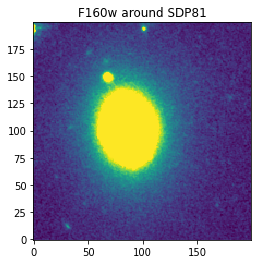

In [11]:
corte = img.subimage(center=CentralPx, unit_center=u.deg,size=18,unit_size=u.arcsec)
corte.info()
corte.plot(title='F160w around SDP81', zscale=True)

**center**: centro onde será feito po corte. Formato é (y,x) = (DEC,RA)

**unit_center**: unidades do centro, em astropy units. Se valor for None, então é assumido px

**size**: tamanho do corte, em astropy units

**unit_size**: unidades do tamanho d corte, em astropy units. Se o valor for None, então é assumido px

[INFO] 200 x 200 Image (/home/carlos/Documents/Dados Projeto/SDP.81/Hubble/hst_12194_01_wfc3_ir_f160w_drz.fits)
[INFO] .data(200 x 200) (no unit), no noise
[INFO] center:(00:39:06.5657,09:03:11.519) size:(18.000",18.000") step:(0.090",0.090") rot:0.0 deg frame:FK5


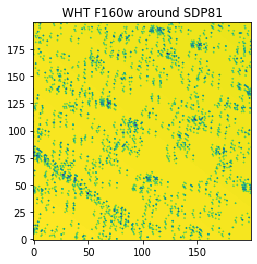

In [5]:
#Plotando o corte acima
corte_wht = wht_f160w.subimage(center=CentralPx, unit_center=u.deg,size=18,unit_size=u.arcsec)
corte_wht.info()
corte_wht.plot(title='WHT F160w around SDP81')

In [6]:
def dist_circle(xc, yc, s):
    """
    Returns an array in which the value of each element is its distance from
    a specified center. Useful for masking inside a circular aperture.

    The (xc, yc) coordinates are the ones one can read on the figure axes
    e.g. when plotting the result of my find_galaxy() procedure.

    """
    x, y = np.ogrid[:s[0], :s[1]] - np.array([yc, xc])  # note yc before xc
    rad = np.sqrt(x**2 + y**2)

    return rad

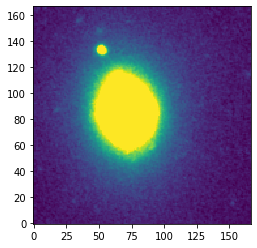

In [7]:
#Abrindo a imagem com a galáxia, que já passou pelo MGE
    #Nessa passagem foi determinado o px central como sendo: Img[j, k]: 86 70
f160w = Image("/home/carlos/autolens_workspace/SDP81/Data/F160W_centerized.fits", ext=1)

f160w.plot(zscale=True)


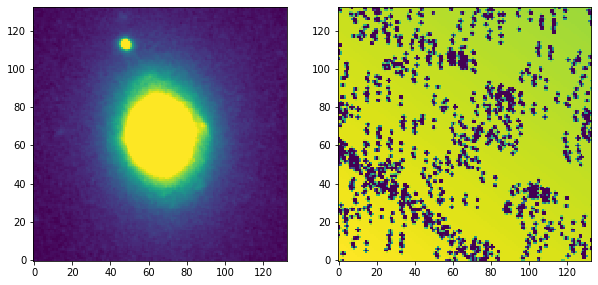

In [8]:
#Agora cortamos ambos (imagem + wht_img) ao redor do px central do MGE

MGE_center = (86, 70)        #px


img_final = f160w.subimage(center=MGE_center, unit_center=None, size=12, unit_size=u.arcsec)
wht_final = corte_wht.subimage(center=MGE_center, unit_center=None, size=12, unit_size=u.arcsec)



plt.figure(figsize=(10,8))

plt.subplot(121)
img_final.plot(zscale=True)


plt.subplot(122)
wht_final.plot(zscale=True)


In [13]:
mask = img_final.data > 0


    # Mask a nearby galaxy
mask &= dist_circle(48, 113, img_final.shape) < 5


In [14]:
img_final.mask = mask

In [49]:
pos = np.where(mask == False)

In [50]:
#Sky subtract
sky = 0.3
img_final.data = img_final.data - 0.3

#masking
img_final[pos] = 0

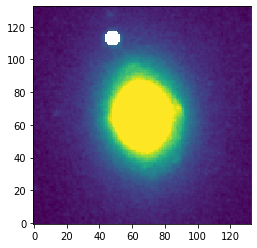

In [15]:


img_final.plot(zscale=True)

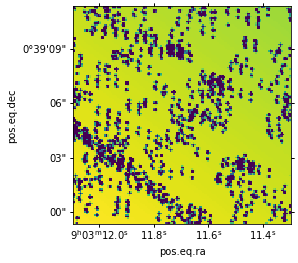

In [16]:
wht_final.plot(zscale=True, use_wcs=True)

In [17]:
#Salvando em .fits
img_final.write('/home/carlos/autolens_workspace/SDP81/Data/F160w_img.fits')
wht_final.write('/home/carlos/autolens_workspace/SDP81/Data/WHT_Image.fits')

Agora vamos importar os pacotes do Pyautolens para converter a imagem WHT para o Noise-Map em RMS standard deviations.

In [10]:
import autofit as af
import autolens as al
import autolens.plot as aplt

Setup the path to our current working directory.

In [11]:
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


Loading Data From Individual Fits Files

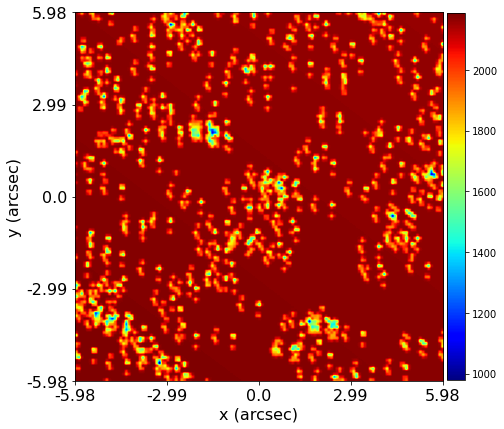

In [12]:
dataset_path = af.util.create_path(
    path=f"{workspace_path}/", folders=["SDP81"]
)

imaging_path = af.util.create_path(path=dataset_path, folders=["Data"])

weight_map = al.Array.from_fits(
    file_path=imaging_path + "WHT_Image.fits", pixel_scales=0.09, hdu=1
)

aplt.Array(array=weight_map)

In [13]:
file_path=imaging_path + "WHT_Image.fits"

__Noise Conversions__
There are many different ways the noise-map can be reduced. We are aiming to include conversion functions for all 
common data-reductions. For example, the noise-map may be a HST WHT map, where RMS SD = 1.0/ sqrt(WHT). Note how 
the values of the noise-map go to very large values in excess of 10000 how you can see above.

This can be converted to a noise-map using the preprocess module.

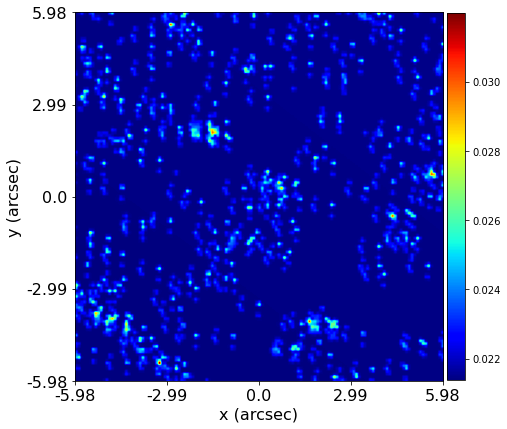

In [14]:
noise_map = al.preprocess.noise_map_from_weight_map(weight_map=weight_map)

aplt.Array(array=noise_map)

In [16]:
#Saving the Noise-Map
noise_map.output_to_fits(file_path=f"{dataset_path}/Data/noise_map.fits")